## 데이터 불러오기

In [125]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('./drive/MyDrive/Personal_Training_To_Github/Dacon/train_df.csv',encoding = 'cp949')
submission_test_origin = pd.read_csv('./drive/MyDrive/Personal_Training_To_Github/Dacon/test_df.csv',encoding = 'cp949')
submission = pd.read_csv('./drive/MyDrive/Personal_Training_To_Github/Dacon/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 파악 및 EDA

In [124]:
# import module

!pip install category_encoders
!pip install lightgbm
!pip install catboost # https://dailyheumsi.tistory.com/136

import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import tensorflow as tf
import catboost as cb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

from tensorflow.keras.datasets.boston_housing import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.layers import LSTM

from lightgbm import LGBMRegressor
from lightgbm import plot_metric

#train.head() # INVC_CONT 예측 -> 회귀로 가야함
# index : 인덱스
# SEND_SPG_INNB : 송하인_격자공간고유번호
# REC_SPG_INNB : 수하인 격자공간고유번호
# DL_GD_LCLS_NM : 카테고리_대
# DL_GD_MCLS_NM : 카테고리_중, 라벨링 시 관계 고려.
# INVC_CONT : 운송장 건 수

#https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=edizon426&logNo=220907308092
#③ 격자 번호 : 격자는 고유식별이 가능하도록 “단위격자크기+고유좌표”로 구성된 ID를 부여
# 5 5 3 3
# 시군구코드 1000m 격자공간 고유번호, 100m격자공간 고유번호, 50m격자공간 고유번호
# [출처] 행정정보의 격자체계 설정 및 공간정보화 기준 [지오코딩규정]|작성자 주소도령

#len(set(train_df['DL_GD_MCLS_NM'])) # 20
#set(train_df['REC_AREA']) - set(train_df['SEND_AREA']) # 없는 것들도 존재 => label encoding은 불가? # {28720, 31110, 41830, 42790, 42830, 43800, 44760, 44790, ... }

In [99]:
train

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9
3,3,1154500002014200,5011000315087400,식품,농산물,10
4,4,1165000021008300,5011000177051200,식품,가공식품,3
...,...,...,...,...,...,...
31995,31995,5011001060063300,2635000026053400,식품,농산물,6
31996,31996,5011001095042400,1168000017002200,식품,기타식품,5
31997,31997,5011001108036200,4119700008012100,식품,농산물,9
31998,31998,5011001115011400,1132000015085100,식품,농산물,3


In [101]:
submission_test_origin

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,32000,5013000043028400,1165000021097200,식품,농산물
1,32001,5013000044016100,1154500002066400,식품,농산물
2,32002,5013000205030200,4139000102013200,식품,농산물
3,32003,5013000205030200,4221000040093400,식품,농산물
4,32004,5013000268011400,2726000004017100,식품,농산물
...,...,...,...,...,...
4635,36635,5013000858004400,4725000719072200,식품,농산물
4636,36636,5013000870018300,2826000106075300,식품,농산물
4637,36637,5013000897086300,4311100034004300,식품,농산물
4638,36638,5013000902065100,4145000013011200,식품,농산물


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


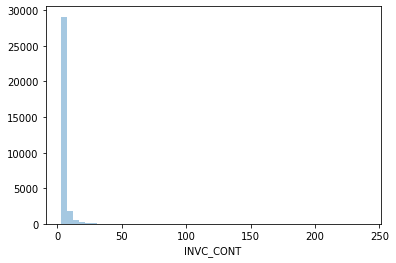

In [97]:
ax = sns.distplot(train['INVC_CONT'],kde=False,hist=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 40.0)

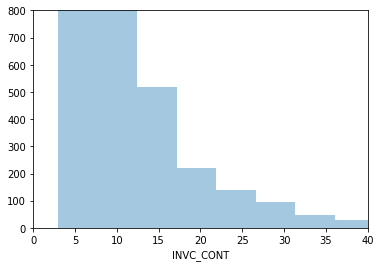

In [98]:
ax = sns.distplot(train['INVC_CONT'],kde=False,hist=True);
ax.set_ylim([0, 800])
ax.set_xlim([0, 40])

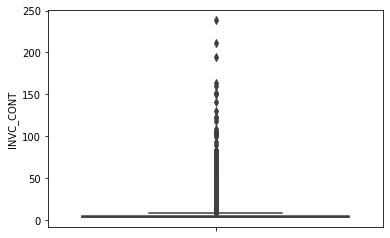

In [94]:
ax = sns.boxplot(y = train['INVC_CONT']);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 40.0)

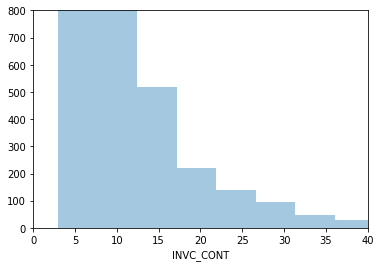

In [96]:
ax = sns.boxplot(y = train['INVC_CONT']);
ax.set_ylim([0, 20])

In [ ]:
print(train['SEND_SPG_INNB'].shape) # (32000,)
print(train['REC_SPG_INNB'].shape) # (32000,)

t_0 = list(set(train['SEND_SPG_INNB'])) # 송하인 지역코드 갯수
print(len(t_0)) # 3684
t_1 = list(set(train['REC_SPG_INNB'])) # 수하인 지역코드 갯수
print(len(t_1)) # 27826

t = t_0 + t_1
s_t = set(t) 
print(len(t)) # 31510, 송하인과 수하인의 지역코드 갯수 합
print(len(s_t)) # 30942, 겹치는 부분도 존재.

## 데이터 전처리

In [ ]:
# 카테고리 변수 모든 인코딩 바법
#https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/#h2_9

In [ ]:
train_df = train # 사용할 train_df 생성
submission_test_origin_df = submission_test_origin # 사용할 submission_test_origin_df 생성

train_df.iloc[:,1:3] = train_df.iloc[:,1:3].astype('str') #  slicing을 위한 타입 변환
submission_test_origin_df.iloc[:,1:3] = submission_test_origin_df.iloc[:,1:3].astype('str') #  slicing을 위한 타입 변환

send_columns = ['SEND_AREA','SEND_1000','SEND_100','SEND_50'] # SEND_SPG_INNB를 나눌 열목록의 이름
rec_columns = ['REC_AREA','REC_1000','REC_100','REC_50'] # REC_SPG_INNB 나눌 열목록의 이름

lambda_0 = lambda x : x[:5] # 첫번째 슬라이싱 함수
lambda_1 = lambda x : x[5:10] # 두번째 슬라이싱 함수
lambda_2 = lambda x : x[10:13] # 세번째 슬라이싱 함수
lambda_3 = lambda x : x[13:] # 네번째 슬라이싱 함수

train_df[send_columns[0]] = list(map(lambda_0 , train_df['SEND_SPG_INNB'])) # 첫번째 슬라이싱 진행
train_df[send_columns[1]] = list(map(lambda_1 , train_df['SEND_SPG_INNB'])) # 두번째 슬라이싱 진행
train_df[send_columns[2]] = list(map(lambda_2 , train_df['SEND_SPG_INNB'])) # 세번째 슬라이싱 진행
train_df[send_columns[3]] = list(map(lambda_3 , train_df['SEND_SPG_INNB'])) # 네번째 슬라이싱 진행

train_df[rec_columns[0]] = list(map(lambda_0 , train_df['REC_SPG_INNB'])) # 위와 동일
train_df[rec_columns[1]] = list(map(lambda_1 , train_df['REC_SPG_INNB']))
train_df[rec_columns[2]] = list(map(lambda_2 , train_df['REC_SPG_INNB']))
train_df[rec_columns[3]] = list(map(lambda_3 , train_df['REC_SPG_INNB']))

train_df = train_df.drop(['index','SEND_SPG_INNB','REC_SPG_INNB'], axis=1) # 필요 없는 열 제거
train_df = train_df[['SEND_AREA','SEND_1000','SEND_100','SEND_50','REC_AREA','REC_1000','REC_100','REC_50','DL_GD_LCLS_NM','DL_GD_MCLS_NM','INVC_CONT']] # 열 name 순으로 정렬
train_df.iloc[:,:8] = train_df.iloc[:,:8].astype('int') # 정수형으로 데이터 타입 변경

submission_test_origin_df[send_columns[0]] = list(map(lambda_0 , submission_test_origin_df['SEND_SPG_INNB'])) # model.predict를 위한 test 데이터 변환 작업
submission_test_origin_df[send_columns[1]] = list(map(lambda_1 , submission_test_origin_df['SEND_SPG_INNB'])) # 위 train_df 와 동일
submission_test_origin_df[send_columns[2]] = list(map(lambda_2 , submission_test_origin_df['SEND_SPG_INNB']))
submission_test_origin_df[send_columns[3]] = list(map(lambda_3 , submission_test_origin_df['SEND_SPG_INNB']))

submission_test_origin_df[rec_columns[0]] = list(map(lambda_0  , submission_test_origin_df['REC_SPG_INNB']))
submission_test_origin_df[rec_columns[1]] = list(map(lambda_1 , submission_test_origin_df['REC_SPG_INNB']))
submission_test_origin_df[rec_columns[2]] = list(map(lambda_2 , submission_test_origin_df['REC_SPG_INNB']))
submission_test_origin_df[rec_columns[3]] = list(map(lambda_3 , submission_test_origin_df['REC_SPG_INNB']))

submission_test_origin_df = submission_test_origin_df.drop(['index','SEND_SPG_INNB','REC_SPG_INNB'], axis=1)
submission_test_origin_df = submission_test_origin_df[['SEND_AREA','SEND_1000',	'SEND_100',	'SEND_50','REC_AREA','REC_1000','REC_100','REC_50', 'DL_GD_LCLS_NM','DL_GD_MCLS_NM',]]
submission_test_origin_df.iloc[:,:8] = submission_test_origin_df.iloc[:,:8].astype('int')
train_df

In [127]:
encoder= ce.BinaryEncoder(cols=['SEND_AREA','REC_AREA'],return_df=True)
train_df=encoder.fit_transform(train_df) 
submission_test_origin_df = encoder.fit_transform(submission_test_origin_df)
train_df

,SEND_AREA_0,SEND_AREA_1,SEND_AREA_2,SEND_AREA_3,SEND_AREA_4,SEND_AREA_5,SEND_AREA_6,SEND_AREA_7,SEND_1000,SEND_100,SEND_50,REC_AREA_0,REC_AREA_1,REC_AREA_2,REC_AREA_3,REC_AREA_4,REC_AREA_5,REC_AREA_6,REC_AREA_7,REC_1000,REC_100,REC_50,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,0,0,0,0,0,0,1,14,45,300,0,0,0,0,0,0,0,1,220,46,300,패션의류,상의,3
1,0,0,0,0,0,0,1,0,9,51,200,0,0,0,0,0,0,0,1,178,37,300,생활/건강,반려동물,3
2,0,0,0,0,0,0,1,0,30,93,100,0,0,0,0,0,0,0,1,265,91,400,패션의류,기타패션의류,9
3,0,0,0,0,0,0,1,1,2,14,200,0,0,0,0,0,0,0,1,315,87,400,식품,농산물,10
4,0,0,0,0,0,1,0,0,21,8,300,0,0,0,0,0,0,0,1,177,51,200,식품,가공식품,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0,0,1,0,1,0,0,1,1060,63,300,0,1,0,0,0,0,0,0,26,53,400,식품,농산물,6
31996,0,0,1,0,1,0,0,1,1095,42,400,0,1,0,0,1,0,1,0,17,2,200,식품,기타식품,5
31997,0,0,1,0,1,0,0,1,1108,36,200,1,1,1,0,0,0,1,1,8,12,100,식품,농산물,9
31998,0,0,1,0,1,0,0,1,1115,11,400,0,1,0,1,1,1,1,0,15,85,100,식품,농산물,3


In [163]:
df = train_df
#df = train_df[train_df['INVC_CONT'] <= 100] # 이상치 제거를 해보았으나, 높은 것들도 모두 작게 측정하는 오류로 인하여 test결과 값이 안좋게나옴.
submission_test = submission_test_origin_df

#df = pd.get_dummies(df, columns=['DL_GD_LCLS_NM','DL_GD_MCLS_NM'] ) # 원핫 인코딩 진행 => 변수가 너무 많아져 불편

#df['SEND_SPG_INNB'] = df['SEND_SPG_INNB'].astype('category')
#df['REC_SPG_INNB'] = df['REC_SPG_INNB'].astype('category')
#df['DL_GD_LCLS_NM'] = df['DL_GD_LCLS_NM'].astype('category')
#df['DL_GD_MCLS_NM'] = df['DL_GD_MCLS_NM'].astype('category')

SEND_SPG_le = LabelEncoder() # 데이터 라벨링 진행
SEND_SPG_le.fit(df['DL_GD_LCLS_NM'])

REC_SPG_le = LabelEncoder()
REC_SPG_le.fit(df['DL_GD_MCLS_NM'])

df['DL_GD_LCLS_NM'] = SEND_SPG_le.transform(df['DL_GD_LCLS_NM']) # 대분류 X 중분류 파생변수를 만들어서 라벨링 진행해 볼 것.
df['DL_GD_MCLS_NM'] = REC_SPG_le.transform(df['DL_GD_MCLS_NM'])

submission_test['DL_GD_LCLS_NM'] = SEND_SPG_le.transform(submission_test['DL_GD_LCLS_NM'])
submission_test['DL_GD_MCLS_NM'] = REC_SPG_le.transform(submission_test['DL_GD_MCLS_NM'])
submission_test.iloc[:,:8] = submission_test.iloc[:,:8].astype('int')
df.iloc[:,:8] = df.iloc[:,:8].astype('int')

df['LCLS_MCLS'] = df['DL_GD_LCLS_NM'] * 100 + df['DL_GD_MCLS_NM'] # 새로운 파생변수 LCLS_MCLS 생성 대분류 * 100 + 중분류
submission_test['LCLS_MCLS'] = submission_test['DL_GD_LCLS_NM'] * 100 + submission_test['DL_GD_MCLS_NM'] 

df = df.drop(columns=['DL_GD_LCLS_NM','DL_GD_MCLS_NM'])
submission_test = submission_test.drop(columns=['DL_GD_LCLS_NM','DL_GD_MCLS_NM'])
df#[['DL_GD_LCLS_NM'	,'SEND_100',	'SEND_50','REC_1000',	'REC_100',	'REC_50',		'LCLS_MCLS','INVC_CONT']]

,SEND_AREA_0,SEND_AREA_1,SEND_AREA_2,SEND_AREA_3,SEND_AREA_4,SEND_AREA_5,SEND_AREA_6,SEND_AREA_7,SEND_1000,SEND_100,SEND_50,REC_AREA_0,REC_AREA_1,REC_AREA_2,REC_AREA_3,REC_AREA_4,REC_AREA_5,REC_AREA_6,REC_AREA_7,REC_1000,REC_100,REC_50,INVC_CONT,LCLS_MCLS
0,0,0,0,0,0,0,0,1,14,45,300,0,0,0,0,0,0,0,1,220,46,300,3,412
1,0,0,0,0,0,0,1,0,9,51,200,0,0,0,0,0,0,0,1,178,37,300,3,111
2,0,0,0,0,0,0,1,0,30,93,100,0,0,0,0,0,0,0,1,265,91,400,9,406
3,0,0,0,0,0,0,1,1,2,14,200,0,0,0,0,0,0,0,1,315,87,400,10,208
4,0,0,0,0,0,1,0,0,21,8,300,0,0,0,0,0,0,0,1,177,51,200,3,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0,0,1,0,1,0,0,1,1060,63,300,0,1,0,0,0,0,0,0,26,53,400,6,208
31996,0,0,1,0,1,0,0,1,1095,42,400,0,1,0,0,1,0,1,0,17,2,200,5,205
31997,0,0,1,0,1,0,0,1,1108,36,200,1,1,1,0,0,0,1,1,8,12,100,9,208
31998,0,0,1,0,1,0,0,1,1115,11,400,0,1,0,1,1,1,1,0,15,85,100,3,208


In [ ]:
df = df.drop(columns=['SEND_1000',	'SEND_100',	'SEND_50',	'REC_1000',	'REC_100',	'REC_50']) # 송하인, 수하인 지역만 가지고 예측 진행 => 결과가 좋지 않음.
submission_test = submission_test.drop(columns=['SEND_1000',	'SEND_100',	'SEND_50',	'REC_1000',	'REC_100',	'REC_50'])
df.corr()

In [ ]:
'''from sklearn.preprocessing import StandardScaler, MinMaxScaler

five_min_, five_max_ = 0, 100000 # 5자리 코드에 대한 min_max_scaler
#df['SEND_AREA'] = (df['SEND_AREA'] - five_min_) / (five_max_ - five_min_) 
#df['REC_AREA'] = (df['REC_AREA'] - five_min_) / (five_max_ - five_min_)
df['SEND_1000'] = (df['SEND_1000'] - five_min_) / (five_max_ - five_min_)
df['REC_1000'] = (df['REC_1000'] - five_min_) / (five_max_ - five_min_)

#submission_test['SEND_AREA'] = (submission_test['SEND_AREA'] - five_min_) / (five_max_ - five_min_)
#submission_test['REC_AREA'] = (submission_test['REC_AREA'] - five_min_) / (five_max_ - five_min_)
submission_test['SEND_1000'] = (submission_test['SEND_1000'] - five_min_) / (five_max_ - five_min_)
submission_test['REC_1000'] = (submission_test['REC_1000'] - five_min_) / (five_max_ - five_min_)

three_min_, three_max_ = 0, 999 # 3자리 코드에 대한 min_max_scaler
df['SEND_100'] = (df['SEND_100'] - three_min_) / (three_max_ - three_min_)
df['SEND_50'] = (df['SEND_50'] - three_min_) / (three_max_ - three_min_)
df['REC_100'] = (df['REC_100'] - three_min_) / (three_max_ - three_min_)
df['REC_50'] = (df['REC_50'] - three_min_) / (three_max_ - three_min_)

submission_test['SEND_100'] = (submission_test['SEND_100'] - three_min_) / (three_max_ - three_min_)
submission_test['SEND_50'] = (submission_test['SEND_50'] - three_min_) / (three_max_ - three_min_)
submission_test['REC_100'] = (submission_test['REC_100'] - three_min_) / (three_max_ - three_min_)
submission_test['REC_50'] = (submission_test['REC_50'] - three_min_) / (three_max_ - three_min_)

df'''

'''
from sklearn.preprocessing import LabelEncoder

df = train_df[train_df['INVC_CONT'] <= 50] # 66개만 제거
#df = df.iloc[:,1:]

# prepare input data
def prepare_inputs(X_train,range_list):
	X_train_enc = list()
	# label encode each column
	for i in range_list:
		le = LabelEncoder()
		le.fit(X_train.iloc[:, i])
		# encode
		train_enc = le.transform(X_train.iloc[:, i])
		# store
		X_train_enc.append(train_enc)
	return X_train_enc

df_enc = prepare_inputs(df,[3,4])
#df['SEND_SPG_INNB'] = df_enc[0]
#df['REC_SPG_INNB'] = df_enc[1]
df['DL_GD_LCLS_NM'] = df_enc[0]
df['DL_GD_MCLS_NM'] = df_enc[1]


t = pd.concat([df['SEND_SPG_INNB'], df['REC_SPG_INNB']], axis=0)
le = LabelEncoder()
le.fit(t)
t = le.transform(t)
print(t.shape) # 63868
df['SEND_SPG_INNB'] = t[:t.shape[0]//2]
df['REC_SPG_INNB'] = t[t.shape[0]//2:]
df.isnull().sum()

df'''

'''def preprocessing(df):
    for i in df.columns:
        if i == 'INVC_CONT':
            continue
        ms = MinMaxScaler()
        sd = StandardScaler()
        z = ms.fit_transform(df[i].values.reshape(-1,1))
        df[i] = z
    return df

df = preprocessing(df)
df'''

## 데이터 모델링

In [171]:
def tt_split(df): # 데이터 분할
	df_train = df.drop('INVC_CONT',axis=1) 
	df_test = df['INVC_CONT']

	x_train_full, x_test, y_train_full, y_test = train_test_split(df_train, df_test, test_size=0.3, random_state=111)
	x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3, random_state=111)
	return x_train, x_val, y_train, y_val, x_test,  y_test

x_train, x_val, y_train, y_val, x_test,  y_test = tt_split(df)

### LGBMR

[1]	valid_0's l2: 47.257	valid_0's l2: 47.257
Training until validation scores don't improve for 300 rounds.
[2]	valid_0's l2: 46.8337	valid_0's l2: 46.8337
[3]	valid_0's l2: 46.487	valid_0's l2: 46.487
[4]	valid_0's l2: 46.2141	valid_0's l2: 46.2141
[5]	valid_0's l2: 45.9562	valid_0's l2: 45.9562
[6]	valid_0's l2: 45.6901	valid_0's l2: 45.6901
[7]	valid_0's l2: 45.4612	valid_0's l2: 45.4612
[8]	valid_0's l2: 45.2278	valid_0's l2: 45.2278
[9]	valid_0's l2: 45.0341	valid_0's l2: 45.0341
[10]	valid_0's l2: 44.8785	valid_0's l2: 44.8785
[11]	valid_0's l2: 44.7542	valid_0's l2: 44.7542
[12]	valid_0's l2: 44.5612	valid_0's l2: 44.5612
[13]	valid_0's l2: 44.3994	valid_0's l2: 44.3994
[14]	valid_0's l2: 44.3248	valid_0's l2: 44.3248
[15]	valid_0's l2: 44.2152	valid_0's l2: 44.2152
[16]	valid_0's l2: 44.1446	valid_0's l2: 44.1446
[17]	valid_0's l2: 43.9764	valid_0's l2: 43.9764
[18]	valid_0's l2: 43.8191	valid_0's l2: 43.8191
[19]	valid_0's l2: 43.6845	valid_0's l2: 43.6845
[20]	valid_0's l2: 

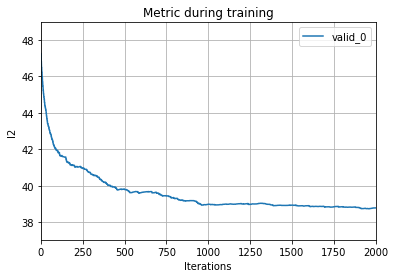

In [38]:
model = LGBMRegressor(n_estimators=1000)
evals = [(x_val, y_val)] # 검증 세트
model.fit(x_train,y_train,
          early_stopping_rounds=300,
          eval_metric='mse',
          #categorical_feature=[0,4] ,
          eval_set=evals)#,verbose=True)

cross_val= cross_validate(
    estimator=model,
    X=x_train, y=y_train,
    cv=5
)

pred = model.predict(x_test)
RMSE = mean_squared_error(y_test, pred)**0.5
print('RMSE : ', RMSE) #  5.510919174025457

plot_metric(model); # 5.575357658621653 -> 5.491964056903956 category화 진행시 조금 줄어듦

### Catboost

In [111]:
train_dataset = cb.Pool(x_train, y_train) 
test_dataset = cb.Pool(x_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)

model.fit(x_train,y_train)

pred = model.predict(x_test)

RMSE = mean_squared_error(y_test, pred)**0.5

print('RMSE : ', RMSE)
rmse = mean_squared_error(y_test, pred)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
162:	learn: 4.9755619	test: 4.3890465	best: 4.2998996 (30)	total: 1000ms	remaining: 227ms
163:	learn: 4.9742195	test: 4.3883907	best: 4.2998996 (30)	total: 1.01s	remaining: 221ms
164:	learn: 4.9730191	test: 4.3889732	best: 4.2998996 (30)	total: 1.02s	remaining: 216ms
165:	learn: 4.9722861	test: 4.3903754	best: 4.2998996 (30)	total: 1.03s	remaining: 212ms
166:	learn: 4.9716779	test: 4.3915430	best: 4.2998996 (30)	total: 1.04s	remaining: 206ms
167:	learn: 4.9693568	test: 4.3937034	best: 4.2998996 (30)	total: 1.04s	remaining: 199ms
168:	learn: 4.9682429	test: 4.3923883	best: 4.2998996 (30)	total: 1.06s	remaining: 195ms
169:	learn: 4.9673722	test: 4.3927368	best: 4.2998996 (30)	total: 1.07s	remaining: 189ms
170:	learn: 4.9669216	test: 4.3924525	best: 4.2998996 (30)	total: 1.08s	remaining: 183ms
171:	learn: 4.9656581	test: 4.3931691	best: 4.2998996 (30)	total: 1.08s	remaining: 177ms
172:	learn: 4.9644880	test: 4.3923731	best: 4.2998996 (30)	total: 1.09s	r

### SGDRegressor

In [ ]:
model = SGDRegressor(loss='squared_loss') #SGD회귀, 5.2470321692105255e+39
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:169: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  FutureWarning,


SGDRegressor(loss='squared_loss')

### LSTM, MLP

In [157]:
x_train

,SEND_AREA_0,SEND_AREA_1,SEND_AREA_2,SEND_AREA_3,SEND_AREA_4,SEND_AREA_5,SEND_AREA_6,SEND_AREA_7,SEND_1000,SEND_100,SEND_50,REC_AREA_0,REC_AREA_1,REC_AREA_2,REC_AREA_3,REC_AREA_4,REC_AREA_5,REC_AREA_6,REC_AREA_7,REC_1000,REC_100,REC_50,DL_GD_LCLS_NM,DL_GD_MCLS_NM,LCLS_MCLS
24227,0,0,1,1,1,0,0,1,748,80,100,0,0,0,0,0,0,0,1,672,81,200,2,14,214
21549,0,0,1,0,1,0,0,1,437,99,200,0,0,1,1,0,1,1,0,122,84,400,2,8,208
23956,0,0,1,0,1,0,0,1,78,68,400,0,0,1,0,1,1,0,1,286,88,300,2,8,208
7046,0,0,1,0,1,0,0,1,78,68,400,0,1,0,1,0,1,1,0,47,88,200,2,8,208
23640,0,0,1,0,1,0,0,1,78,68,400,1,0,1,0,0,0,1,1,10,15,100,2,8,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,0,1,1,0,1,0,0,1,537,41,200,0,0,0,0,0,0,0,1,265,99,200,2,1,201
20400,0,0,1,0,1,0,1,0,610,49,100,0,0,0,1,0,0,1,0,40,52,400,2,8,208
20062,0,0,1,0,1,0,1,0,366,24,400,1,0,1,0,0,0,1,0,24,46,100,2,8,208
14204,0,0,1,0,1,0,0,1,685,67,100,0,0,1,0,1,0,1,0,20,98,200,2,8,208


In [ ]:
model = Sequential([Dense(64, activation='relu', input_shape=(24,), name='dense1'), #  (None, 100)               1400  # Dense => LSTM
                    Dense(32, activation='relu', name='dense2'), # (None, 64)                6464 
                    Dense(16, activation='relu', name='dense3'), # (None, 32)                2080 
                    Dense(1, name='output'),]) # (None, 1)                 33
model.summary() # c 노말리제이션을 하면 relu랑 잘 맞음?

# compile하는 과정으로 모델의 학습 방법등을 정의 하는 것
model.compile(loss='mse',  # 훈련 하는 동안 모델의 오차를 측정
              optimizer =Adam(learning_rate=1e-3), # 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법
              metrics=['mse']) # 훈련 단계와 테스트 단계를 모니터링

history = model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_val, y_val))


history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val))

model.evaluate(x_test,y_test)
print(history.history.keys()) # dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color='blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color='red', label = 'val_loss')
ax1.set_title('Train and Validatain Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mse']
val_mae = history_dict['val_mse']


ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, mae, color='blue', label = 'train_mes')
ax2.plot(epochs, val_mae, color='red', label = 'val_mse')
ax2.set_title('Train and Validation mae')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.grid()
ax2.legend()

plt.show()

# LSTM(20) X
# DENSE(64,32,16,1) loss: 3.6376 - mse: 3.6376
# RMSE :  5.461432611052749

In [ ]:
from sklearn.metrics import mean_squared_error

pred = model.predict(y_test)
RMSE = mean_squared_error(y_test, pred)**0.5
print('RMSE : ', RMSE)

RMSE :  5.461432611052749


## 정답파일 생성

In [133]:
submission_test = submission_test.iloc[:,:].astype('int')
submission_test.describe()

,SEND_AREA_0,SEND_AREA_1,SEND_AREA_2,SEND_AREA_3,SEND_AREA_4,SEND_AREA_5,SEND_AREA_6,SEND_AREA_7,SEND_1000,SEND_100,SEND_50,REC_AREA_0,REC_AREA_1,REC_AREA_2,REC_AREA_3,REC_AREA_4,REC_AREA_5,REC_AREA_6,REC_AREA_7,REC_1000,REC_100,REC_50,LCLS_MCLS
count,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000
mean,0.008190,0.040733,0.476293,0.137931,0.560776,0.107543,0.079741,0.914224,444.965948,51.104741,244.612069,0.238147,0.506897,0.353448,0.593103,0.391379,0.412931,0.625216,0.534483,211.301509,49.948276,248.836207,210.209698
std,0.090135,0.197692,0.499491,0.344865,0.496346,0.309836,0.270922,0.280063,302.876266,26.243767,116.632810,0.425995,0.500006,0.478092,0.491308,0.488112,0.492414,0.484119,0.498863,247.985547,29.316786,112.922069,50.348223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,100.000000,4.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,137.000000,30.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,24.000000,100.000000,208.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,437.000000,55.000000,200.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,94.000000,50.000000,250.000000,208.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,731.000000,68.000000,400.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,341.250000,75.000000,400.000000,208.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1128.000000,100.000000,400.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1547.000000,100.000000,400.000000,515.000000


In [134]:
# test 데이터 예측

#submission_test_res= submission_test.drop('index',axis=1)
#df_enc = prepare_inputs(submission_test_res,[2,3])
# df['SEND_SPG_INNB'] = df_enc[0]
# df['REC_SPG_INNB'] = df_enc[1]
#submission_test_res['DL_GD_LCLS_NM'] = df_enc[0]
#submission_test_res['DL_GD_MCLS_NM'] = df_enc[1]

#submission_test_res['SEND_SPG_INNB'] = submission_test_res['SEND_SPG_INNB'].astype('category')
#submission_test_res['REC_SPG_INNB'] = submission_test_res['REC_SPG_INNB'].astype('category')
#submission_test_res['DL_GD_LCLS_NM'] = submission_test_res['DL_GD_LCLS_NM'].astype('category')
#submission_test_res['DL_GD_MCLS_NM'] = submission_test_res['DL_GD_MCLS_NM'].astype('category')
#submission_test_res = preprocessing(submission_test_res)

pred = model.predict(submission_test)
submission['INVC_CONT'] = pred
submission.to_csv('baseline.csv',index = False) # 왼쪽 라이브러리 목록에 보면 저장 되어있음을 알 수 있음.

In [ ]:
submission_test_res

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,1.0,0.013839,0.4,0.421053
1,1.0,0.011148,0.4,0.421053
2,1.0,0.776012,0.4,0.421053
3,1.0,0.797027,0.4,0.421053
4,1.0,0.413890,0.4,0.421053
...,...,...,...,...
4635,1.0,0.926192,0.4,0.421053
4636,1.0,0.439518,0.4,0.421053
4637,1.0,0.820118,0.4,0.421053
4638,1.0,0.777550,0.4,0.421053
